# AutoML model

In this notebook, we demonstrate how to:
- prepare time series data for training a forecasting model using an automated ML model builder
- Creating an Experiment using an existing Workspace
- Configure AutoML using 'AutoMLConfig'
- Train the model on local compute 
- Explore the engineered features and results
- Configuration and run AutoML for a time-series model with lag and rolling window features
- Run and explore the forecast
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load and temperature data only.

This notebook is based on the energy forecasting notebook provided [here](https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand/auto-ml-forecasting-energy-demand.ipynb).

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

## Imports
We start with the usual imports and settings

In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

import numpy as np
np.set_printoptions(precision=2)

# Squash warning messages for cleaner output in the notebook
import warnings
warnings.showwarning = lambda *args, **kwargs: None
warnings.filterwarnings("ignore")

## Data
Load the data from csv into a Pandas dataframe. Make sure to first complete the [0_data_setup](../0_data_setup.ipynb) notebook.

In [2]:
import os

file_name = os.path.join('../data', 'energy.parquet')
energy = pd.read_parquet(file_name)
energy.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


## Create train, validation and test sets

We separate our dataset into train, validation and test sets. We train the model on the train set. The validation set is used to evaluate the model after each training epoch and ensure that the model is not overfitting the training data. After the model has finished training, we evaluate the model on the test set. We must ensure that the validation set and test set cover a later period in time from the training set, to ensure that the model does not gain from information from future time periods.

We will allocate data as follows:
* November 1, 2014 to December 31, 2014:  **test** set. 
* September 1, 2014 to October 31, 2014:  **validation** set. 
* Everything up to August 31, 2014: **training** set.

In [3]:
valid_start_dt = '2014-08-31 23:59:59'
test_start_dt = '2014-10-31 23:59:59'

## Data preparation - training set

AutoML takes care of a lot of the details. We simply need to prepare a Pandas DataFrame for each of Train, Test, and Validation.

*HORIZON=1* specifies that we have a forecasting horizon of 1 (*t+1*)

In [4]:
HORIZON = 1

Our data preparation for the training set will involve the following steps:

1. Create a time column from the index
2. Filter the original dataset to include only that time period reserved for the training set
3. Drop rown with missing values 

### 1. Add time column

In [5]:
energy['timestamp'] = energy.index

### 2. Filter the original dataset to include only that time period reserved for each set
Create training, test and validations sets

In [6]:
ds_train = energy[:valid_start_dt].copy()
ds_valid = energy[valid_start_dt:test_start_dt].copy()
ds_test = energy[test_start_dt:].copy()

Verify that the series are continuous.

In [7]:
print(ds_train.tail())
print(ds_valid.head())

                        load  temp           timestamp
2014-08-31 19:00:00 3,969.00 74.67 2014-08-31 19:00:00
2014-08-31 20:00:00 3,869.00 74.00 2014-08-31 20:00:00
2014-08-31 21:00:00 3,643.00 73.00 2014-08-31 21:00:00
2014-08-31 22:00:00 3,365.00 72.00 2014-08-31 22:00:00
2014-08-31 23:00:00 3,097.00 71.33 2014-08-31 23:00:00
                        load  temp           timestamp
2014-09-01 00:00:00 2,886.00 71.00 2014-09-01 00:00:00
2014-09-01 01:00:00 2,768.00 70.00 2014-09-01 01:00:00
2014-09-01 02:00:00 2,699.00 69.33 2014-09-01 02:00:00
2014-09-01 03:00:00 2,681.00 68.33 2014-09-01 03:00:00
2014-09-01 04:00:00 2,690.00 68.33 2014-09-01 04:00:00


### 3. Discard any samples with missing values
We will discard these.

In [8]:
ds_train.dropna(how="any", inplace=True)
ds_valid.dropna(how="any", inplace=True)
ds_test.dropna(how="any", inplace=True)

We now have data of shape:

In [9]:
print('Train data shape:', ds_train.shape)
print('Valid data shape:', ds_valid.shape)
print('Test data shape:', ds_test.shape)

Train data shape: (23376, 3)
Valid data shape: (1464, 3)
Test data shape: (1464, 3)


## Set Up AzureML Workspace

As part of the setup you should have access to an Azure ML Workspace. For Automated ML you will need to create an Experiment object, which is a named object in a Workspace used to run experiments.

In [10]:
import azureml.core
from azureml.core import Experiment, Workspace

assert os.path.exists('config.json'), 'Download `config.json` from the Auzre Portal and place in this folder'
ws = Workspace.from_config()

# Define a project folder where artifacts will be stored
project_folder = './project'
os.makedirs(project_folder, exist_ok=True)

# choose a name for the run history container in the workspace
experiment_name = 'automl-forecasting-GEFCom2014'
experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment_name
output['Project Folder'] = project_folder
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.74
Workspace,AML2
Resource Group,AML2
Location,southcentralus
Experiment Name,automl-forecasting-GEFCom2014
Project Folder,./project


## Create/Attach Remote Compute
Create the AmlCompute target in your workspace if it doesn't already exist.

You can also configure several advanced properties when you create Azure Machine Learning Compute. The properties allow you to create a persistent cluster of fixed size, or within an existing Azure Virtual Network in your subscription. See the [AmlCompute class](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.compute.amlcompute.amlcompute?view=azure-ml-py) for details.

In [11]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cluster_name = "cpucluster"

# Verify that cluster does not exist already
try:
    aml_compute = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing cluster, using it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(
        vm_size='STANDARD_D2_V2',
        # for GPU, use "STANDARD_NC6"
        # vm_priority = 'lowpriority', # optional
        max_nodes=6
    )
    aml_compute = ComputeTarget.create(ws, cluster_name, compute_config)

Found existing cluster, using it.


## Wait for compute to spin up
Can poll for a minimum number of nodes and for a specific timeout.
If no min_node_count is provided, it will use the scale settings for the cluster.


In [12]:
aml_compute.wait_for_completion(
    show_output=True, 
    min_node_count=None, 
    timeout_in_minutes=10
)

Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned


## Data for Remote Compute
We have to make the datasets available to the remote compute nodes. Easiest is to upload to the default datastore associated with the AML Workspace

In [13]:
from azureml.core.dataset import Dataset
from azureml.data.data_reference import DataReference

# First save our training sets as CSV files
data_dir = os.path.join('..', 'data')
ds_train.to_csv(os.path.join(data_dir, 'ds_train.csv'), index=False)
ds_valid.to_csv(os.path.join(data_dir, 'ds_valid.csv'), index=False)

# Upload to AML DataStore
ds = ws.get_default_datastore()
files = [os.path.join('..', 'data', x) for x in ['ds_train.csv', 'ds_valid.csv']]
ds.upload_files(files, target_path='GEFCom2014', overwrite=True, show_progress=True)

# Create Data References
train_data_ref = ds.path('GEFCom2014/ds_train.csv')
valid_data_ref = ds.path('GEFCom2014/ds_valid.csv')

# Define as AML Datasets
amlds_train = Dataset.Tabular.from_delimited_files(train_data_ref)
amlds_valid = Dataset.Tabular.from_delimited_files(valid_data_ref)

Uploading an estimated of 2 files
Uploading ../data/ds_train.csv
Uploading ../data/ds_valid.csv
Uploaded ../data/ds_valid.csv, 1 files out of an estimated total of 2
Uploaded ../data/ds_train.csv, 2 files out of an estimated total of 2
Uploaded 2 files


## Train

Instantiate an AutoMLConfig object. This config defines the settings and data used to run the experiment. We can provide extra configurations within 'automl_settings', for this forecasting task we add the name of the time column and the maximum forecast horizon. See [here](https://docs.microsoft.com/en-us/python/api/azureml-train-automl-client/azureml.train.automl.automlconfig.automlconfig?view=azure-ml-py) for more options.

|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>|
|**blacklist_models**|Models in blacklist won't be used by AutoML. All supported models can be found at [here](https://docs.microsoft.com/en-us/python/api/azureml-train-automl/azureml.train.automl.constants.supportedmodels.regression?view=azure-ml-py).|
|**experiment_timeout_minutes**|Maximum amount of time in minutes that the experiment take before it terminates.|
|**training_data**|The training data to be used within the experiment.|
|**label_column_name**|The name of the label column.|
|**compute_target**|The remote compute for training.|
|**n_cross_validations**|Number of cross validation splits. Rolling Origin Validation is used to split time-series in a temporally consistent way.|
|**enable_early_stopping**|Flag to enble early termination if the score is not improving in the short term.|\n",
|**time_column_name**|The name of your time column.|
|**max_horizon**|The number of periods out you would like to predict past your training data. Periods are inferred from your data.|

In [14]:
import logging
from azureml.train.automl import AutoMLConfig

#These models are blacklisted for tutorial purposes, remove this for real use cases.                            
blacklist_models = ['ExtremeRandomTrees', 'AutoArima', 'ElasticNet']

automl_config = AutoMLConfig(
    # AzureML Settings
    compute_target=aml_compute,
    max_concurrent_iterations=2,
    max_cores_per_iteration=6,
    # Data Parameters
    training_data=amlds_train,
    validation_data=amlds_valid,
    time_column_name='timestamp',
    label_column_name='load',
    # Forecasting Parameters
    task='forecasting',
    max_horizon=HORIZON,
    primary_metric='normalized_root_mean_squared_error',
    # AutoML Settings
    enable_early_stopping=True,
    blacklist_models=blacklist_models,
    experiment_timeout_minutes=10,
    verbosity=logging.ERROR,
    path=project_folder,
)

### Submit the job

Call the submit method on the experiment object and pass the run configuration. Depending on the data and the number of iterations this can run for a while. 

The optional `show_output=True` causes currently running iterations to print to the console.

In [15]:
run = experiment.submit(automl_config)

The `run` object contains a link to the experiment in the AzureML Workspace.

In [16]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-forecasting-GEFCom2014,AutoML_adfa081b-6599-4b73-87bf-13bf35a20f1d,automl,Starting,Link to Azure Machine Learning studio,Link to Documentation


Wait for run to complete

In [17]:
%%time

status = run.wait_for_completion(show_output=True)


****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   StandardScalerWrapper RandomForest             0:01:05       0.0476    0.0476
         1   StandardScalerWrapper LightGBM                 0:02:01       0.0660    0.0476
         2   StandardScalerWrapper LassoLars                0:01:46       0.1518    0.0476
         3   MinMaxScaler DecisionTree                      0:01:45       0.0826    0.0476
         4   MaxAbsScaler RandomForest                      0:01:45       0.0459    

### Retrieve the Best Model
Below we select the best model from all the training iterations using the `get_output` method.

In [18]:
best_run, fitted_model = run.get_output()
#fitted_model.steps

## Analysis
Below we take a look at the model produced

### Featurization
You can access the engineered feature names generated in time-series featurization

In [19]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['temp',
 'temp_WASNULL',
 'year',
 'half',
 'quarter',
 'month',
 'day',
 'hour',
 'am_pm',
 'hour12',
 'wday',
 'qday',
 'week']

### View featurization summary
You can also see what featurization steps were performed on different raw features in the user data. For each input field in the user data, the following information is displayed:

- Raw field name
- Number of engineered features formed out of this raw field
- Type detected
- If the feature was dropped
- List of feature transformations for the raw field

In [20]:
# Get the featurization summary as a list of JSON
featurization_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()
# View the featurization summary as a pandas dataframe
pd.DataFrame.from_records(featurization_summary)

,Dropped,EngineeredFeatureCount,RawFeatureName,Transformations,TypeDetected
0,No,2,temp,"[MeanImputer, ImputationMarker]",Numeric
1,No,11,timestamp,"[DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer]",DateTime


## Forecasting
Now that we have retrieved the best pipeline/model, it can be used to make predictions on test data.

### Forecast Function
For forecasting, we will use the forecast function instead of the predict function. There are two reasons for this.

We need to pass the recent values of the target variable y, whereas the scikit-compatible predict function only takes the non-target variables 'test'. In our case, the test data immediately follows the training data, and we fill the target variable with NaN. The NaN serves as a question mark for the forecaster to fill with the actuals. Using the forecast function will produce forecasts using the shortest possible forecast horizon. The last time at which a definite (non-NaN) value is seen is the forecast origin - the last time when the value of the target is known.

Using the predict method would result in getting predictions for EVERY horizon the forecaster can predict at. This is useful when training and evaluating the performance of the forecaster at various horizons, but the level of detail is excessive for normal use.

In [21]:
# First, we remove the target values from the test set:
X_test = ds_test.copy()
y_test = X_test.pop('load').values

# The forecast origin will be at the beginning of the first forecast period.
# (Which is the same time as the end of the last training period.)
y_query = np.empty_like(y_test)
y_query.fill(np.nan)

# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_predictions, X_trans = fitted_model.forecast(X_test, y_query)

It is useful to look at how the inputs were transformed to create the predictions

In [22]:
X_trans.head()

,,temp,temp_WASNULL,year,half,quarter,month,day,hour,am_pm,hour12,wday,qday,week,_automl_target_col
timestamp,_automl_dummy_grain_col,,,,,,,,,,,,,,
2014-11-01 00:00:00,_automl_dummy_grain_col,38.33,0,2014,2,4,11,1,0,0,0,5,32,44,2482.78
2014-11-01 01:00:00,_automl_dummy_grain_col,37.33,0,2014,2,4,11,1,1,0,1,5,32,44,2417.21
2014-11-01 02:00:00,_automl_dummy_grain_col,36.33,0,2014,2,4,11,1,2,0,2,5,32,44,2386.46
2014-11-01 03:00:00,_automl_dummy_grain_col,36.33,0,2014,2,4,11,1,3,0,3,5,32,44,2386.71
2014-11-01 04:00:00,_automl_dummy_grain_col,36.00,0,2014,2,4,11,1,4,0,4,5,32,44,2390.30


### Evaluate
To evaluate the accuracy of the forecast, we'll compare against the actual load values using the mean absolute percentage error (MAPE) metric.

Collect the target and predictions in a dataset

In [23]:
eval_df = ds_test.copy().drop('timestamp', axis=1)
eval_df['prediction'] = y_predictions
eval_df.rename(columns={'load':'actual'}, inplace=True)
eval_df.head()

,actual,temp,prediction
2014-11-01 00:00:00,2514.00,38.33,2482.78
2014-11-01 01:00:00,2434.00,37.33,2417.21
2014-11-01 02:00:00,2390.00,36.33,2386.46
2014-11-01 03:00:00,2382.00,36.33,2386.71
2014-11-01 04:00:00,2419.00,36.00,2390.30


Compute the mean absolute percentage error over all predictions

In [24]:
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

In [25]:
print("MAPE: {:.2f}%".format(100* mape(eval_df['prediction'], eval_df['actual'])))

MAPE: 3.55%


Plot the predictions vs the actuals for the first week of the test set

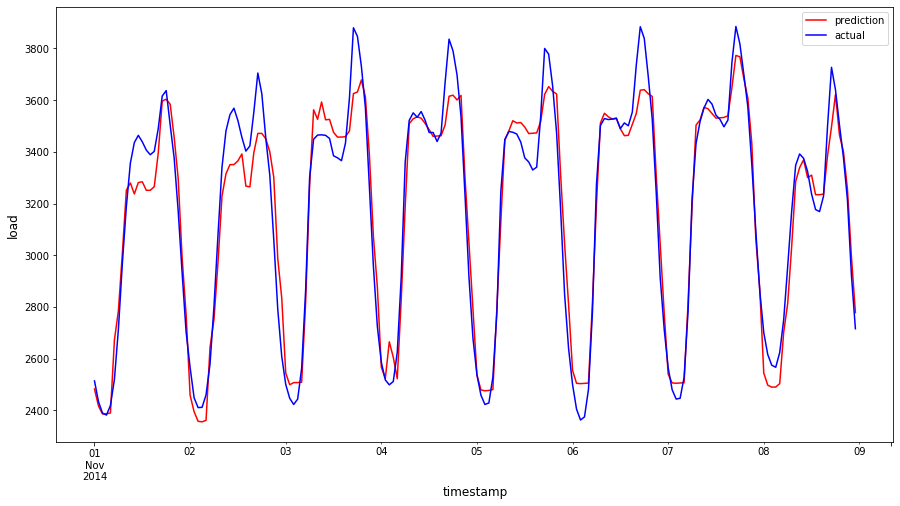

In [26]:
eval_df[:'2014-11-08'] \
    .plot(y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [27]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'NOTSET', …